<a href="https://colab.research.google.com/github/mazinad/AdminUserAuth/blob/master/BigData_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Анализ 5V (Big Data)


In [1]:
# Опционально: примонтировать Google Drive (если данные в Drive)
from google.colab import drive
print('Если хотите использовать Google Drive — разкомментируйте следующую строку:')
# drive.mount('/content/drive')

Если хотите использовать Google Drive — разкомментируйте следующую строку:


In [2]:
# Установим необходимые библиотеки. Выполняйте эту ячейку в Colab.
# Great Expectations и fastavro устанавливаются опционально — они нужны для проверки качества и Avro-конверсии.
!pip install pyarrow fastparquet fastavro pandas matplotlib --quiet
# Great Expectations может занять время и место; включите при желании:
# !pip install great_expectations --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 100.2 MB/s eta 0:00:00


In [3]:
import os, math, json, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def bytes2human(n):
    # Convert bytes to human-readable string
    symbols = ('B','KB','MB','GB','TB','PB')
    prefix = {}
    for i,s in enumerate(symbols[1:],1):
        prefix[s] = 1 << (i*10)
    for s in reversed(symbols[1:]):
        if n >= prefix[s]:
            value = float(n) / prefix[s]
            return '%.2f %s' % (value, s)
    return '%.2f B' % (n)

def file_info(path):
    s = os.path.getsize(path)
    return {'path': path, 'size_bytes': s, 'size_human': bytes2human(s)}

In [4]:
# Укажите здесь путь к вашему файлу (или перетащите файл в Colab и вставьте путь)
DATA_PATH = '/content/Airline_Delay_Cause.csv'

# Авто-детект расширения
_, ext = os.path.splitext(DATA_PATH.lower())
print('Detected extension:', ext)

Detected extension: .csv


In [6]:
def count_rows_csv(path, chunksize=10**6):
    # Быстро посчитать строки без загрузки всего файла
    total = 0
    for chunk in pd.read_csv(path, chunksize=chunksize, low_memory=True):
        total += len(chunk)
    return total

def load_sample_or_full(path, nrows=None, parse_dates=None):
    _, ext = os.path.splitext(path.lower())
    if ext in ('.parquet', '.pq'):
        df = pd.read_parquet(path)
    elif ext in ('.csv', '.txt'):
        df = pd.read_csv(path, nrows=nrows, parse_dates=parse_dates, low_memory=False)
    else:
        raise ValueError('Unsupported extension: ' + ext)
    return df

# safe row counting (only run if file exists in the environment)
if os.path.exists(DATA_PATH):
    info = file_info(DATA_PATH)
    print('File:', info['path'], 'size:', info['size_human'])
    if DATA_PATH.lower().endswith('.csv'):
        print('Counting rows (this may take time for large files)...')
        try:
            rows = count_rows_csv(DATA_PATH, chunksize=200000)
            print('Rows (CSV):', rows)
        except Exception as e:
            print('Row counting failed:', e)
else:
    print('File not found at', DATA_PATH)

File: /content/Airline_Delay_Cause.csv size: 323.90 KB
Counting rows (this may take time for large files)...
Rows (CSV): 1951


In [7]:
# Функция для автоматического поиска столбцов с датой/временем в образце данных
def detect_datetime_column(df, top_k=3):
    candidates = []
    for col in df.columns:
        low = col.lower()
        if any(k in low for k in ('date','time','timestamp','pickup','dropoff','fl_date')):
            candidates.append(col)
    # Также попробуем попытаться преобразовать типы
    parsed = []
    for col in df.columns:
        try:
            sample = df[col].dropna().astype(str).iloc[:100]
            pd.to_datetime(sample, infer_datetime_format=True)
            parsed.append(col)
        except Exception:
            continue
    # Merge and prioritize
    result = []
    for c in candidates + parsed:
        if c not in result:
            result.append(c)
    return result[:top_k]

# Usage example (load small sample first)
if os.path.exists(DATA_PATH):
    try:
        sample = load_sample_or_full(DATA_PATH, nrows=10000)
        print('Columns detected:', list(sample.columns)[:50])
        dt_cols = detect_datetime_column(sample)
        print('Potential datetime cols:', dt_cols)
    except Exception as e:
        print('Could not read sample:', e)

Columns detected: ['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
Potential datetime cols: ['year']


/tmp/ipython-input-941283277.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime(sample, infer_datetime_format=True)
/tmp/ipython-input-941283277.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime(sample, infer_datetime_format=True)
/tmp/ipython-input-941283277.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argumen

In [8]:
# ---- Volume analysis ----
if os.path.exists(DATA_PATH):
    info = file_info(DATA_PATH)
    print('File size:', info['size_human'])
    _, ext = os.path.splitext(DATA_PATH.lower())
    if ext == '.csv':
        # число строк
        try:
            rows = count_rows_csv(DATA_PATH, chunksize=200000)
            print('Rows:', rows)
            avg_row_bytes = info['size_bytes'] / rows if rows else None
            print('Avg row size: {:.2f} bytes'.format(avg_row_bytes) if avg_row_bytes else 'N/A')
            # оценка Parquet сжатия (эмпирическая): Parquet часто даёт 3-5x сжатие для табличных данных
            est_parquet_size = info['size_bytes'] / 3.5
            print('Estimated parquet size (approx):', bytes2human(est_parquet_size))
        except Exception as e:
            print('Could not compute rows/parquet estimate:', e)
    elif ext in ('.parquet', '.pq'):
        # если Parquet — используем метаданные
        try:
            df = pd.read_parquet(DATA_PATH, engine='pyarrow')
            rows = len(df)
            print('Rows (parquet read):', rows)
            print('In-memory sample info: columns =', len(df.columns))
        except Exception as e:
            print('Could not read parquet:', e)
else:
    print('Set DATA_PATH to a real file first.')

File size: 323.90 KB
Rows: 1951
Avg row size: 170.00 bytes
Estimated parquet size (approx): 92.54 KB


In [9]:
# Convert CSV to Parquet (if input is CSV). This speeds up further runs.
OUT_DIR = '/content/outputs'
os.makedirs(OUT_DIR, exist_ok=True)
if os.path.exists(DATA_PATH) and DATA_PATH.lower().endswith('.csv'):
    out_path = os.path.join(OUT_DIR, os.path.basename(DATA_PATH).rsplit('.',1)[0] + '.parquet')
    print('Converting to Parquet:', out_path)
    try:
        # Use chunks to avoid OOM for very large files
        reader = pd.read_csv(DATA_PATH, chunksize=200000, low_memory=False)
        first = True
        for i, chunk in enumerate(reader):
            chunk.to_parquet(out_path, engine='pyarrow', index=False, compression='snappy', append=not first)
            first = False
            if i % 10 == 0:
                print('Wrote chunk', i)
        print('Conversion done. Parquet saved to', out_path)
    except Exception as e:
        print('Conversion failed:', e)
else:
    print('No CSV to convert or file missing.')

Converting to Parquet: /content/outputs/Airline_Delay_Cause.parquet
Conversion failed: __cinit__() got an unexpected keyword argument 'append'


Using DATE_COL = year


/tmp/ipython-input-941283277.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime(sample, infer_datetime_format=True)
/tmp/ipython-input-941283277.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime(sample, infer_datetime_format=True)
/tmp/ipython-input-941283277.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argumen

,count
date_only,
1970-01-01,1951


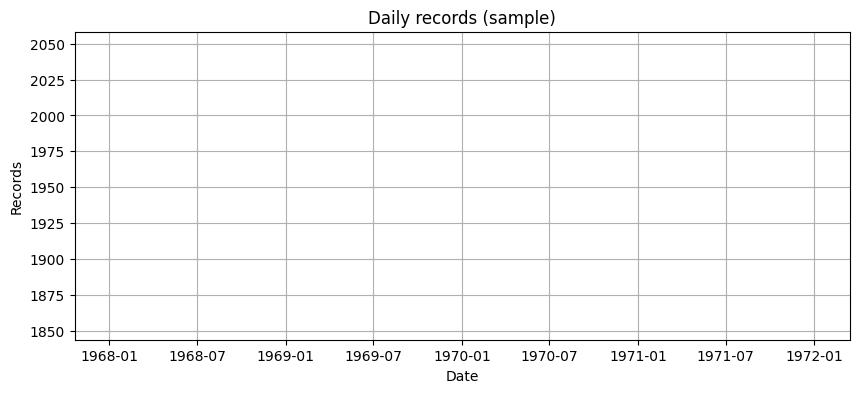

Approx avg records/sec (sample): None
Peak records per 5-minute interval (sample): 1951


/tmp/ipython-input-2421234730.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  counts_5min = df.resample('5T').size()


In [10]:
# ---- Daily growth & velocity ----
DATE_COL = None  # <-- установите имя столбца с датой/временем, если обнаружено автоматически, оставьте None

if os.path.exists(DATA_PATH):
    # Load a sample or full data depending on size
    _, ext = os.path.splitext(DATA_PATH.lower())
    if ext in ('.parquet', '.pq'):
        df = pd.read_parquet(DATA_PATH)
    else:
        # read in chunks but parse date column if provided
        if DATE_COL:
            df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL], low_memory=False)
        else:
            df = pd.read_csv(DATA_PATH, nrows=200000, low_memory=False)
    # Detect date col if not provided
    if DATE_COL is None:
        dt_candidates = detect_datetime_column(df)
        DATE_COL = dt_candidates[0] if dt_candidates else None
    print('Using DATE_COL =', DATE_COL)
    if DATE_COL is not None:
        # ensure datetime type
        df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
        df = df.dropna(subset=[DATE_COL])
        df['date_only'] = df[DATE_COL].dt.date
        daily_counts = df.groupby('date_only').size().rename('count')
        display(daily_counts.head())
        # plot daily counts
        plt.figure(figsize=(10,4))
        daily_counts.plot()
        plt.title('Daily records (sample)')
        plt.xlabel('Date')
        plt.ylabel('Records')
        plt.grid(True)
        plt.savefig('/content/outputs/daily_counts.png')
        plt.show()
        # compute avg per second and peak 5-minute window (sample)
        df = df.set_index(DATE_COL).sort_index()
        total_seconds = (df.index.max() - df.index.min()).total_seconds()
        avg_per_sec = len(df) / total_seconds if total_seconds>0 else None
        print('Approx avg records/sec (sample):', avg_per_sec)
        # peak 5-min window
        counts_5min = df.resample('5T').size()
        peak_5min = counts_5min.max()
        print('Peak records per 5-minute interval (sample):', peak_5min)
    else:
        print('No datetime column found — velocity analysis requires a timestamp column.')

In [11]:
# ---- Variety analysis ----
if 'df' in globals():
    types = df.dtypes.apply(lambda x: str(x)).rename('dtype')
    counts = pd.DataFrame({'dtype': types})
    counts['is_numeric'] = counts['dtype'].str.contains('int|float|datetime')
    print('Column types summary:')
    display(counts.head(50))
    # Percentage of text columns
    text_cols = [c for c in df.columns if df[c].dtype == object]
    print('Text columns (sample):', text_cols[:10])
    print('Share of text columns:', len(text_cols) / len(df.columns))
else:
    print('Load data first (see previous cells).')

Column types summary:


,dtype,is_numeric
month,int64,True
carrier,object,False
carrier_name,object,False
airport,object,False
airport_name,object,False
arr_flights,float64,True
arr_del15,float64,True
carrier_ct,float64,True
weather_ct,float64,True
nas_ct,float64,True


Text columns (sample): ['carrier', 'carrier_name', 'airport', 'airport_name', 'date_only']
Share of text columns: 0.23809523809523808


In [12]:
# ---- Veracity analysis (missing values, duplicates, simple anomalies) ----
if 'df' in globals():
    missing = df.isnull().mean().sort_values(ascending=False).rename('missing_frac')
    display(missing.head(20))
    print('Total duplicates (sample):', df.duplicated().sum())
    # Simple anomaly checks for numeric columns (negative values)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    anomalies = {}
    for c in numeric_cols:
        neg = (df[c] < 0).sum()
        zeros = (df[c] == 0).sum()
        anomalies[c] = {'negatives': int(neg), 'zeros': int(zeros)}
    print('Numeric anomalies (sample):')
    display(pd.DataFrame(anomalies).T.head(50))
    # Save checks
    missing.to_csv('/content/outputs/missing_frac.csv')
    pd.DataFrame(anomalies).T.to_csv('/content/outputs/numeric_anomalies.csv')
else:
    print('Load data first (see previous cells).')

,missing_frac
nas_ct,0.001025
weather_ct,0.001025
carrier_ct,0.001025
arr_del15,0.001025
arr_flights,0.001025
arr_diverted,0.001025
arr_delay,0.001025
carrier_delay,0.001025
weather_delay,0.001025
nas_delay,0.001025


Total duplicates (sample): 0
Numeric anomalies (sample):


,negatives,zeros
month,0,0
arr_flights,0,0
arr_del15,0,62
carrier_ct,0,87
weather_ct,0,576
nas_ct,0,142
security_ct,0,1685
late_aircraft_ct,0,156
arr_cancelled,0,762
arr_diverted,0,1307


Простая проверка качества данных через Great Expectations

In [ ]:
# Simple Great Expectations example (requires installation)
# Uncomment installation above if you want to run this.
# try:
#     import great_expectations as ge
#     if 'df' in globals():
#         # Create a GE dataframe from pandas and run a single expectation
#         gdf = ge.from_pandas(df.sample(n=min(10000, len(df))))  # sample for speed
#         print('Expect column "amount" to be >= 0 (example)')
#         if 'amount' in gdf.columns:
#             res = gdf.expect_column_values_to_be_between('amount', min_value=0)
#             print(res['success'], res['result']['observed_value'] if 'result' in res else '')
#         else:
#             print('Column "amount" not present in sample — adjust expectation for your dataset.')
#     else:
#         print('Load data into df first.')
# except Exception as e:
#     print('Great Expectations not available or failed:', e)

Fraud Detection

In [13]:
def compute_roi(num_transactions, fraud_rate, avg_loss_per_fraud, detection_improvement, infra_cost_per_year):
    # num_transactions: transactions per year
    # fraud_rate: current fraction of transactions that are fraudulent (0..1)
    # avg_loss_per_fraud: average money lost per fraudulent transaction (currency)
    # detection_improvement: fraction of fraud prevented by system (0..1)
    # infra_cost_per_year: total system cost per year (currency)
    current_annual_loss = num_transactions * fraud_rate * avg_loss_per_fraud
    prevented = current_annual_loss * detection_improvement
    roi = (prevented - infra_cost_per_year) / infra_cost_per_year if infra_cost_per_year else float('inf')
    return {'current_loss': current_annual_loss, 'prevented': prevented, 'infra_cost': infra_cost_per_year, 'ROI': roi}

# Example usage
example = compute_roi(num_transactions=1000000, fraud_rate=0.001, avg_loss_per_fraud=200, detection_improvement=0.3, infra_cost_per_year=50000)
print('Example ROI calculation:', example)

Example ROI calculation: {'current_loss': 200000.0, 'prevented': 60000.0, 'infra_cost': 50000, 'ROI': 0.2}


In [14]:
# Simple heuristic recommendations based on size and velocity
def tech_recommendation(file_size_bytes, avg_per_sec=None, peak_5min=None):
    gb = file_size_bytes / (1024**3)
    rec = []
    if gb < 1:
        rec.append('Pandas / local processing (CSV/Parquet fine)')
    elif gb < 100:
        rec.append('Dask or single-node Spark (if resources allow)')
    else:
        rec.append('Distributed Spark (Databricks / EMR) or BigQuery/Snowflake')
    if avg_per_sec and avg_per_sec > 1000:
        rec.append('Consider Kafka + Flink or Spark Streaming / Managed streaming services')
    if peak_5min and peak_5min > 100000:
        rec.append('Scale ingestion (Kafka partitions), use stream processors and autoscaling compute')
    return rec

if os.path.exists(DATA_PATH):
    info = file_info(DATA_PATH)
    print('Recommendations:', tech_recommendation(info['size_bytes']))

Recommendations: ['Pandas / local processing (CSV/Parquet fine)']


In [15]:
# Save a short summary file for report
summary = {
    'data_path': DATA_PATH,
    'file_info': file_info(DATA_PATH) if os.path.exists(DATA_PATH) else None,
    'note': 'Fill this summary after running all analysis cells.'
}
os.makedirs('/content/outputs', exist_ok=True)
with open('/content/outputs/summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)
print('Summary skeleton saved to /content/outputs/summary.json')

Summary skeleton saved to /content/outputs/summary.json
